# Transect of results and observations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import netCDF4 as nc
import cmocean
import pandas as pd 
import warnings
import pickle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
warnings.filterwarnings('ignore')
import modules.mapping_functions as mf

%matplotlib inline

###### Parameters:

In [15]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# model results:
year           = 2014
month          = 8
results_folder = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-{year}_euphotic/'

# colours:
land_color = '#a9a7a2'

###### Load files:

In [16]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [17]:
Mn_model     = nc.Dataset(f'{results_folder}ANHA12_EXH006_{year}_monthly.nc')
mn_dis       = np.array(Mn_model.variables['dissolmn'])
lat_model    = np.array(Mn_model.variables['nav_lat'])
lon_model    = np.array(Mn_model.variables['nav_lon'])
depths_model = np.array(Mn_model.variables['deptht'])

Observations

In [18]:
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float')
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float')
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float')

In [19]:
GEOTRACES_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = GEOTRACES_data['Station names'].dropna().astype('str')
lons      = GEOTRACES_data['station lon'].astype('float').dropna().values
lats      = GEOTRACES_data['Station lat'].astype('float').dropna().values

###### Functions:

In [20]:
def fill_nans(input_var):
    vector = np.zeros(24)
    for i in range(0,24):
        if i < len(input_var):
            vector[i] = np.array(input_var)[i]
        else:
            vector[i] = np.nan
    return vector

In [21]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

##### Figure of transect along stations:

In [22]:
# Connect these points with straight line segments:
transect_names       = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3']
transect_lons        = np.array([]); transect_lats   = np.array([]);
transect_dMn         = np.zeros((24,len(transect_names)))
transect_depths      = np.zeros((24,len(transect_names)))
transect_distances_m = np.zeros(len(transect_names))
for k,name in enumerate(transect_names):
    transect_lons = np.append(transect_lons, lons[stn_names==name])
    transect_lats = np.append(transect_lats, lats[stn_names==name])
    
    transect_distances_m[k] = mf.haversine(transect_lons[0], transect_lats[0], transect_lons[k], transect_lats[k])
    transect_dMn[:,k]    = fill_nans(Manuel_dMn_nmolL[Manuel_station_names==name].values)
    transect_depths[:,k] = fill_nans(Manuel_depths[Manuel_station_names==name].values)
    
transect_depths_r = transect_depths[::-1, :] #reversed order so that surface points are stacked on top
transect_dMn_r    = transect_dMn[::-1, :] 

In [23]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

In [24]:
# Transect coordinates for observations
transect_i, transect_j = mf.find_indeces_vector(transect_vlons, transect_vlats, mesh_lon, mesh_lat)

transect_bathy       = np.array([])
transect_lons_bathy  = np.array([])
transect_lats_bathy  = np.array([])
transect_distances   = np.array([])
for n in range(0,len(transect_i)):
    if n == 0:
        distance   = 0
    else:
        distance   = mf.haversine(mesh_lon[int(transect_i[0]), int(transect_j[0])],\
                                  mesh_lat[int(transect_i[0]), int(transect_j[0])],\
                                  mesh_lon[int(transect_i[n]), int(transect_j[n])],\
                                  mesh_lat[int(transect_i[n]), int(transect_j[n])])
        
    transect_bathy       = np.append(transect_bathy, mesh_bathy[int(transect_i[n]), int(transect_j[n])])
    transect_lons_bathy  = np.append(transect_lons_bathy, mesh_lon[int(transect_i[n]), int(transect_j[n])])
    transect_lats_bathy  = np.append(transect_lats_bathy, mesh_lat[int(transect_i[n]), int(transect_j[n])])
    transect_distances   = np.append(transect_distances, distance)

In [25]:
# Transect coordinates for model
transect_modeli, transect_modelj = mf.find_indeces_vector(transect_vlons, transect_vlats, lon_model, lat_model)

lons_modelt = np.array([])
lats_modelt = np.array([])
mn_dis_t    = np.zeros((len(depths_model), len(transect_modeli)))
transect_model_distances = np.array([])

for n in range(0,len(transect_modeli)):
    if n == 0:
        distance = 0
    else:
        distance   = mf.haversine(mesh_lon[int(transect_i[0]), int(transect_j[0])],\
                                  mesh_lat[int(transect_i[0]), int(transect_j[0])],\
                                  mesh_lon[int(transect_i[n]), int(transect_j[n])],\
                                  mesh_lat[int(transect_i[n]), int(transect_j[n])])
    lons_modelt = np.append(lons_modelt, lon_model[int(transect_modeli[n]),int(transect_modelj[n])])
    lats_modelt = np.append(lats_modelt, lat_model[int(transect_modeli[n]),int(transect_modelj[n])])
    transect_model_distances = np.append(transect_model_distances, distance)
    
    mn_dis_t[:,n] = mn_dis[month,0,:,int(transect_modeli[n]), int(transect_modelj[n])]

In [26]:
# Station name lables:
transect_names2     = np.copy(transect_names)
transect_names2[5]  = 'CAA6,7'
transect_names2[6]  = ''
transect_names2[7]  = 'CAA4,5'
transect_names2[8]  = ''
transect_names2[9]  = 'CAA1,2,3'
transect_names2[10] = ''
transect_names2[11] = ''

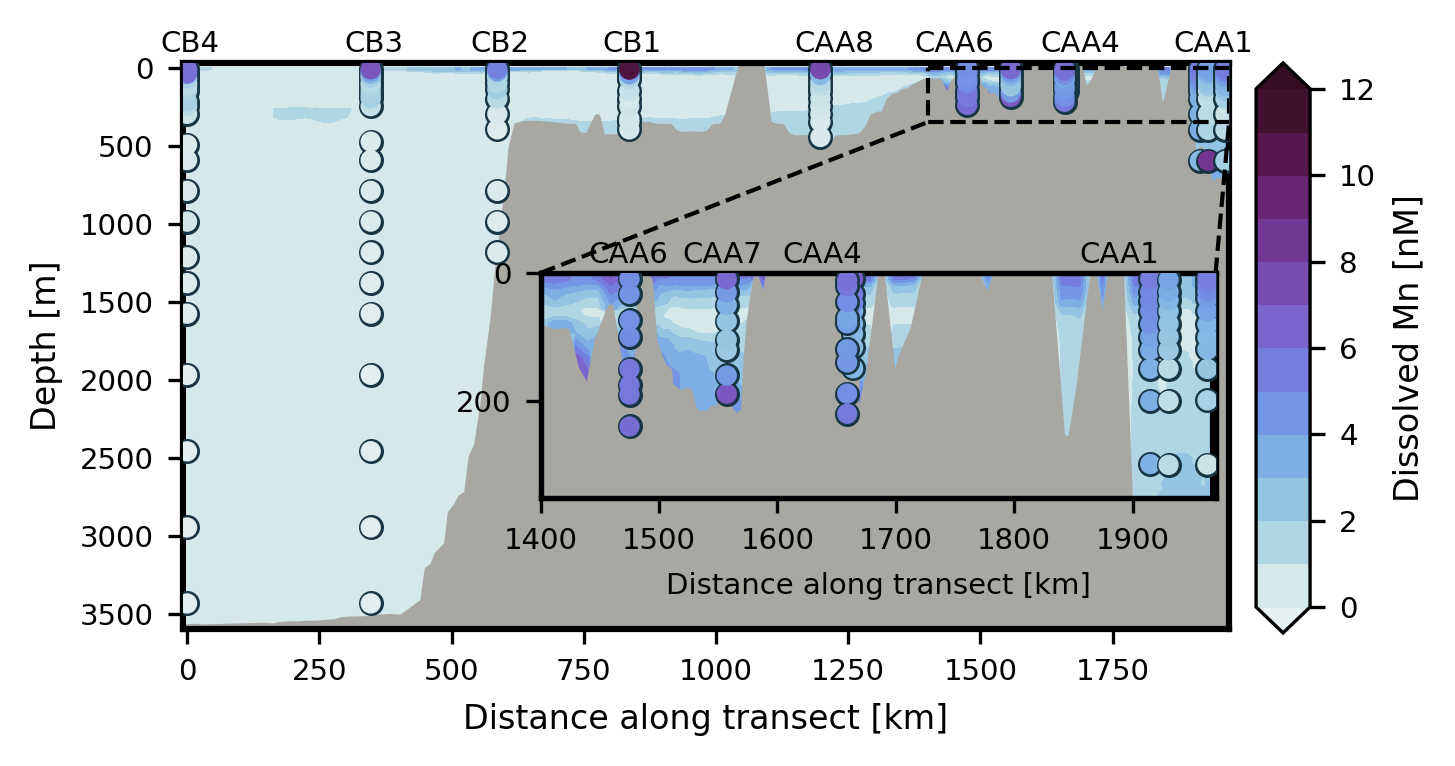

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4.5, 2.5), dpi=300)

# limits for colorbar:
vminmn = 0 
vmaxmn = 12
pointsbg = '#173543'# outline color for scatterpoints

# plot stations:
for i in range(0,len(transect_lons)):
    ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=pointsbg, zorder = 3, s=25)
    sc = ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn_r[:,i], cmap=cmocean.cm.dense,\
                       zorder = 3, s=15)
    if i == 5:
        ax.text(transect_distances_m[i]-100, -100, transect_names2[i], fontsize=7)
    elif i==6:
        ax.text(transect_distances_m[i]-40, -100, transect_names2[i], fontsize=7)
    elif i==9:
        ax.text(transect_distances_m[i]-50, -100, transect_names2[i], fontsize=7)
    else:
        ax.text(transect_distances_m[i]-50, -100, transect_names2[i], fontsize=7)
    
ax.invert_yaxis()
contour = ax.contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.dense, extend='both')
ax.plot(transect_distances, transect_bathy, c=land_color)
ax.fill_between(transect_distances, 4000, transect_bathy, color=land_color, zorder=1)
ax.set_ylabel('Depth [m]', fontsize=8)
ax.set_xlabel('Distance along transect [km]', fontsize=8)
ax.set_ylim([3600, -30])
ax.set_xlim([-8, 1970])
ax.tick_params(axis='both', which='major', labelsize=7)
plt.setp(ax.spines.values(), linewidth=1.5, color='k')

# zoom in:
inset_ax = fig.add_axes([.39, .3, .5, .3], facecolor='k')
for i in range(0,len(transect_lons)):
    inset_ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=pointsbg, zorder = 3, s=25)
    sc = inset_ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn_r[:,i], cmap=cmocean.cm.dense,\
                       zorder = 3, s=15)
    if i==5:
        inset_ax.text(transect_distances_m[i]-35, -15, 'CAA6', fontsize=7)
        inset_ax.text(transect_distances_m[i]+45, -15, 'CAA7', fontsize=7)
    elif i > 4:
        inset_ax.text(transect_distances_m[i]-60, -15, transect_names2[i], fontsize=7)

inset_ax.invert_yaxis()
inset_ax.set_ylim([350, 0])
inset_ax.set_xlim([1400, 1970])
inset_ax.set_xlabel('Distance along transect [km]', fontsize=7)
inset_ax.plot(transect_distances, transect_bathy, c=land_color)
inset_ax.contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.dense, extend='both')
inset_ax.fill_between(transect_distances, 3500, transect_bathy, color=land_color, zorder=1)
inset_ax.tick_params(axis='both', which='major', labelsize=7)
plt.setp(inset_ax.spines.values(), linewidth=1.3, color='k')

cbar_ax = fig.add_axes([0.92, 0.12, 0.04, 0.76])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]', fontsize=8) 
cbar_ax.tick_params(axis='both', which='major', labelsize=7)

mark_inset(ax, inset_ax, loc1=2, loc2=1, fc="none", ec='k', lw=1.0, linestyle='--', zorder=4);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/R2-transect.png', \
               bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/R2-transect.svg', \
               bbox_inches='tight', dpi=300, format='svg')